In [1]:
# %tensorflow_version 2.x

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

tf.random.set_seed(777)
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

## Prepare dataset

In [2]:
words = ['good', 'bad', 'worse', 'so good']
y_data = [1, 0, 0, 1]

char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = { idx : char for idx, char in enumerate(char_set) }
char2idx = { char : idx for idx, char in enumerate(char_set) }

print(char_set)
print(idx2char)
print(char2idx)

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']
{0: '<pad>', 1: ' ', 2: 'a', 3: 'b', 4: 'd', 5: 'e', 6: 'g', 7: 'o', 8: 'r', 9: 's', 10: 'w'}
{'<pad>': 0, ' ': 1, 'a': 2, 'b': 3, 'd': 4, 'e': 5, 'g': 6, 'o': 7, 'r': 8, 's': 9, 'w': 10}


In [3]:
# convert token sequence → indices sequence

x_data = list( map(lambda word : [char2idx.get(char) for char in word], words) )
# x_data = [ [ char2idx.get(char) for char in word ] for word in words ]

x_data_len = list( map( lambda item : len(item), x_data ) )
# x_data_len = [ len(item) for item in x_data ]


print(x_data)
print(x_data_len)

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]
[4, 3, 5, 7]


In [4]:
# add padding
max_sequence = 10
x_data = keras.preprocessing.sequence.pad_sequences(x_data, maxlen=max_sequence, padding='post', truncating='post')

print(x_data)
print(x_data_len)
print(y_data)

[[ 6  7  7  4  0  0  0  0  0  0]
 [ 3  2  4  0  0  0  0  0  0  0]
 [10  7  8  9  5  0  0  0  0  0]
 [ 9  7  1  6  7  7  4  0  0  0]]
[4, 3, 5, 7]
[1, 0, 0, 1]


In [5]:
# generate data pipeline
batch_size = 2
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).shuffle(buffer_size = 4).batch(batch_size)
tr_dataset

<BatchDataset shapes: ((None, 10), (None,)), types: (tf.int32, tf.int32)>

## Create model

In [6]:
input_dim = len(char2idx)
output_dim = len(char2idx)
one_hot = np.eye(len(char2idx))
hidden_size = 10
num_classes = 2

model = keras.Sequential()
model.add( keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim, embeddings_initializer=keras.initializers.Constant(one_hot), trainable=False, mask_zero=True, input_length=max_sequence) )
model.add( keras.layers.SimpleRNN(units=hidden_size) )
model.add( keras.layers.Dense(units=num_classes) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 11)            121       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10)                220       
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


## Define loss function & Select optimizer

In [0]:
def loss_fn( model, x, y ):
  return tf.reduce_mean(keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=model(x), from_logits=True))

lr = 0.01
opt = keras.optimizers.Adam(learning_rate=lr)

## Train model

In [8]:
epochs = 30
tr_loss_hist = []

for epoch in range(epochs):
  avg_tr_loss = 0
  tr_step = 0

  for x_mb, y_mb in tr_dataset:
    with tf.GradientTape() as tape:
      tr_loss = loss_fn(model, x_mb, y_mb)
    grads = tape.gradient(target=tr_loss, sources=model.variables)
    opt.apply_gradients(grads_and_vars=zip(grads, model.variables))

    avg_tr_loss += tr_loss
    tr_step += 1
  else:
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
  
  if (epoch+1)%5 == 0:
    print(f'epoch : {epoch+1:3}  |  tr_loss : {avg_tr_loss.numpy():.4f}')

epoch :   5  |  tr_loss : 0.2572
epoch :  10  |  tr_loss : 0.0897
epoch :  15  |  tr_loss : 0.0328
epoch :  20  |  tr_loss : 0.0158
epoch :  25  |  tr_loss : 0.0095
epoch :  30  |  tr_loss : 0.0066


## Checking performance

prediction : [1 0 0 1]

accuracy : 100.00%



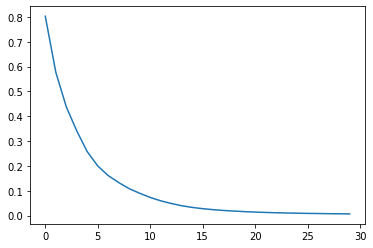

In [9]:
yhat = np.argmax( model.predict(x_data), axis=-1 )

print(f'prediction : {yhat}\n')
print(f'accuracy : {np.mean( yhat==y_data ):.2%}\n')

plt.plot(tr_loss_hist)
plt.show()